#### Voronoi Graphs

In [6]:
import numpy as np
from bresenham import bresenham
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
filename='colliders.csv'
data=np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)


In [7]:
# Here you'll modify the `create_grid()` method from a previous exercise
# In this new function you'll record obstacle centres and
# create a Voronoi graph around those points
def create_grid_and_edges(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    along with Voronoi graph edges given obstacle data and the
    drone's altitude.
    """
    # minimum and maximum north coordinates
    north_min=np.floor(np.min(data[:, 0] - data[:, 3]))
    north_max=np.ceil(np.max(data[:, 0] + data[:, 3]))
    # minimum and maximum east coordinates
    east_min=np.floor(np.min(data[:, 1] - data[:, 4]))
    east_max=np.ceil(np.max(data[:, 1] + data[:, 4]))
    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size=int(np.ceil(north_max - north_min))
    east_size=int(np.ceil(east_max - east_min))
    # Initialize an empty grid
    grid=np.zeros((north_size, east_size))
    # Initialize an empty list for Voronoi points
    points=[]
    # Populate the grid with obstacles
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        if alt + d_alt + safety_distance > drone_altitude:
            obstacle=[
                int(np.clip(north - d_north - safety_distance - north_min, 0, north_size-1)),
                int(np.clip(north + d_north + safety_distance - north_min, 0, north_size-1)),
                int(np.clip(east - d_east - safety_distance - east_min, 0, east_size-1)),
                int(np.clip(east + d_east + safety_distance - east_min, 0, east_size-1)),
            ]
            grid[obstacle[0]:obstacle[1]+1, obstacle[2]:obstacle[3]+1]=1
            # add center of obstacles to points list
            points.append([north-north_min, east-east_min])
    # TODO: create a voronoi graph based on
    # location of obstacle centres
    graph=Voronoi(points)
    # TODO: check each edge from graph.ridge_vertices for collision
    edges=[]
    for v in graph.ridge_vertices:
        p1=graph.vertices[v[0]]
        p2=graph.vertices[v[1]]
        cells=list(bresenham(int(p1[0]), int(p1[1]), int(p2[0]), int(p2[1])))
        hit=False
        for c in cells:
            # First check if we're off the map
            if np.amin(c)<0 or c[0]>=grid.shape[0] or c[1]>=grid.shape[1]:
                hit=True
                break
            # Next check if we're in collision
            if grid[c[0], c[1]] == 1:
                hit=True
                break
        # If the edge does not hit on obstacle
        # add it to the list
        if not hit:
            # array to tuple for future graph creation step
            p1=(p1[0], p1[1])
            p2=(p2[0], p2[1])
            edges.append((p1, p2))
    return grid, edges

In [8]:
# Define a flying altitude (feel free to change this)
drone_altitude=5
safety_distance=3
grid, edges=create_grid_and_edges(data, drone_altitude, safety_distance)
print('Found %5d edges' % len(edges))
print(grid)

Found  1895 edges
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


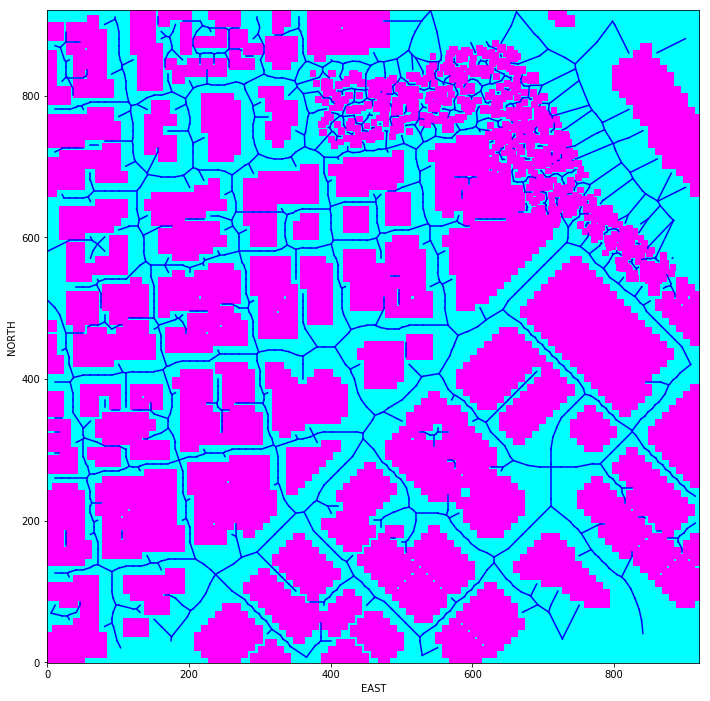

In [45]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
# Plot it up!
plt.rcParams["figure.figsize"] = [12, 12]
plt.imshow(grid, origin='lower', cmap=plt.cm.cool)
# Stepping through each edge
for e in edges:
    p1=e[0]
    p2=e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'blue')
    
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

#### Medial Axis

In [1]:
import numpy as np
from scipy import ndimage
from skimage.morphology import medial_axis
import matplotlib.pyplot as plt

def microstructure(l=256):
    """
    Synthetic binary data: binary microstructure with blobs.

    Parameters
    ----------

    l: int, optional
        linear size of the returned image

    """
    n=5
    x, y=np.ogrid[0:l, 0:l]
    mask_outer=(x-l/2)**2 + (y-l/2)**2 < (l/2)**2
    mask=np.zeros((l, l))
    generator=np.random.RandomState(1)
    points=l * generator.rand(2, n**2)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask=ndimage.gaussian_filter(mask, sigma=l/(4.*n))
    return mask>mask.mean()

data=microstructure(l=64)
# Compute the medial axis (skeleton) and the distance transform
skel, distance=medial_axis(data, return_distance=True)

# Distance to the background for pixels of the skeleton
dist_on_skel=distance*skel

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
ax1.axis('off')
ax2.imshow(dist_on_skel, cmap=plt.cm.gray, interpolation='nearest')
ax2.contour(data, [2.5], color='yellow')
ax2.axis('off')

fig.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)
plt.show()

/Users/88michael/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/Users/88michael/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'color'
  s)


<Figure size 800x400 with 2 Axes>

In [2]:
from enum import Enum
from queue import Queue, PriorityQueue

In [3]:
class Action(Enum):
    """
    An action is represented by a 3 element tuple.
    
    The first 2 values are the delta of the action relative
    to the current grid position. The third and final value
    is the cost of performing the action.
    """
    LEFT = (0, -1, 1)
    RIGHT = (0, 1, 1)
    UP = (-1, 0, 1)
    DOWN = (1, 0, 1)
    
    def __str__(self):
        if self == self.LEFT:
            return '<'
        elif self == self.RIGHT:
            return '>'
        elif self == self.UP:
            return '^'
        elif self == self.DOWN:
            return 'v'
        
    @property   
    def cost(self):
        return self.value[2]
    
    @property
    def delta(self):
        return (self.value[0], self.value[1])

def valid_actions(grid, current_node):
    """
    Returns a list of valid actions given a grid and current node.
    """
    valid = [Action.UP, Action.LEFT, Action.RIGHT, Action.DOWN]
    n, m = grid.shape[0] - 1, grid.shape[1] - 1
    x, y = current_node
    
    # check if the node is off the grid or
    # it's an obstacle
    
    if x - 1 < 0 or grid[x-1, y] == 1:
        valid.remove(Action.UP)
    if x + 1 > n or grid[x+1, y] == 1:
        valid.remove(Action.DOWN)
    if y - 1 < 0 or grid[x, y-1] == 1:
        valid.remove(Action.LEFT)
    if y + 1 > m or grid[x, y+1] == 1:
        valid.remove(Action.RIGHT)
        
    return valid

def visualize_path(grid, path, start):
    """
    Given a grid, path and start position
    return visual of the path to the goal.
    
    'S' -> start 
    'G' -> goal
    'O' -> obstacle
    ' ' -> empty
    """
    sgrid = np.zeros(np.shape(grid), dtype=np.str)
    sgrid[:] = ' '
    sgrid[grid[:] == 1] = 'O'
    
    pos = start
    
    for a in path:
        da = a.value
        sgrid[pos[0], pos[1]] = str(a)
        pos = (pos[0]+da[0], pos[1]+da[1])
    sgrid[pos[0], pos[1]] = 'G'
    sgrid[start[0], start[1]] = 'S'
    return sgrid

In [4]:
def create_grid(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    based on given obstacle data, drone altitude and safety distance
    arguments.
    """

    # minimum and maximum north coordinates
    north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))

    # minimum and maximum east coordinates
    east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))

    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil(north_max - north_min))
    east_size = int(np.ceil(east_max - east_min))

    # Initialize an empty grid
    grid = np.zeros((north_size, east_size))
    
    # Center offset for grid
    north_min_center = np.min(data[:, 0])
    east_min_center = np.min(data[:, 1])

    # Populate the grid with obstacles
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        if alt + d_alt + safety_distance > drone_altitude:
            obstacle = [
                int(np.clip(north - d_north - safety_distance - north_min, 0, north_size-1)),
                int(np.clip(north + d_north + safety_distance - north_min, 0, north_size-1)),
                int(np.clip(east - d_east - safety_distance - east_min, 0, east_size-1)),
                int(np.clip(east + d_east + safety_distance - east_min, 0, east_size-1)),
            ]
            grid[obstacle[0]:obstacle[1]+1, obstacle[2]:obstacle[3]+1] = 1

    return grid

In [5]:
def a_star(grid, h, start, goal):

    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for action in valid_actions(grid, current_node):
                # get the tuple representation
                da = action.delta
                next_node = (current_node[0] + da[0], current_node[1] + da[1])
                branch_cost = current_cost + action.cost
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    branch[next_node] = (branch_cost, current_node, action)
                    queue.put((queue_cost, next_node))
             
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import medial_axis
from skimage.util import invert
plt.rcParams['figure.figsize']=12, 12
filename='colliders.csv'
data=np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [11]:
start_ne=(25, 100)
goal_ne=(750, 800)
drone_altitude=5
safety_distance=2

In [12]:
grid = create_grid(data, drone_altitude, safety_distance)
skeleton=medial_axis(invert(grid))

In [13]:
print(grid)
print(skeleton)

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[False False False ...  True  True  True]
 [False False False ... False False  True]
 [False False False ... False False  True]
 ...
 [False False False ... False False  True]
 [False False False ... False False  True]
 [ True  True  True ...  True  True False]]


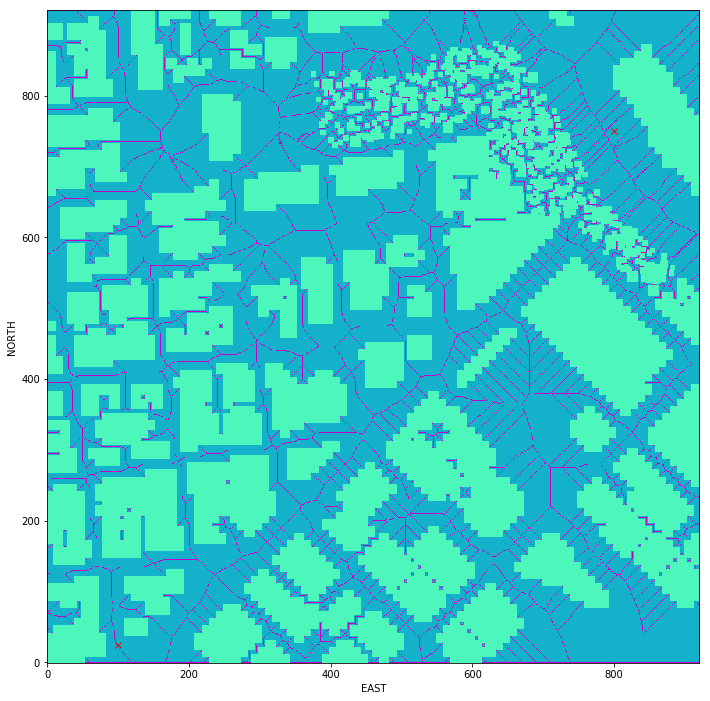

In [14]:
plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower')
plt.imshow(skeleton, cmap='cool', origin='lower', alpha=0.7)
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [85]:
def find_start_goal(skel, start, goal):
    skel_cells=np.transpose(skel.nonzero())
    start_min_dist=np.linalg.norm(np.array(start)-np.array(skel_cells), axis=1).argmin()
    near_start=skel_cells[start_min_dist]
    goal_min_dist=np.linalg.norm(np.array(goal)-np.array(skel_cells), axis=1).argmin()
    near_goal=skel_cells[goal_min_dist]
    return near_start, near_goal
skel_start, skel_goal=find_start_goal(skeleton, start_ne, goal_ne)
print(start_ne, goal_ne)
print(skel_start, skel_goal)

(25, 100) (650, 500)
[24 99] [636 501]


In [86]:
def heuristic_func(position, goal_position):
    return np.sqrt((position[0]-goal_position[0])**2+(position[1]-goal_position[1])**2)

In [88]:
path, cost=a_star(grid, heuristic_func, start_ne, goal_ne)
print("Path length = {0}, path cost = {1}".format(len(path), cost))

Found a path.
Path length = 1026, path cost = 1025.0


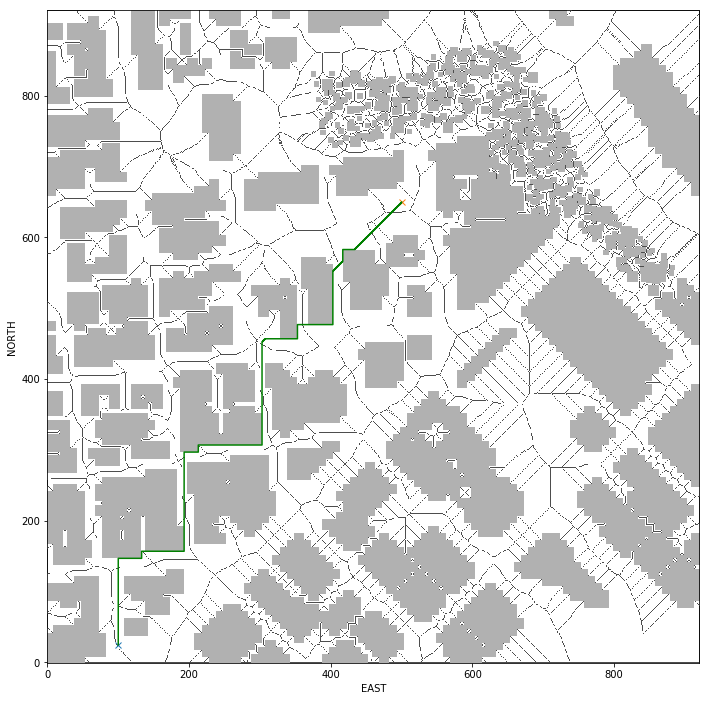

In [89]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')
pp=np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()